In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys

'do nothing' if 'np' not in globals() else np.set_printoptions(3, suppress=True);

ITEM = "0004"

LABEL_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new_mini/route_route0_routes_training_date_05_23_11_36_25/labels/" + ITEM + ".txt"
CAM_FRONT_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new_mini/route_route0_routes_training_date_05_23_11_36_25/CAM_FRONT/" + ITEM + ".jpg"
CAM_FRONT_INSTANCE_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new_mini/route_route0_routes_training_date_05_23_11_36_25/CAM_FRONT_INST/" + ITEM + ".png"
CALIB_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new_mini/route_route0_routes_training_date_05_23_11_36_25/calib/" + ITEM + ".txt"

In [5]:
img_instance = cv2.imread(CAM_FRONT_INSTANCE_PATH)
img_instance = cv2.cvtColor(img_instance, cv2.COLOR_BGR2RGB)
img_instance = np.array(img_instance)
print("img_instance shape: ", img_instance.shape)

# get value of point (200, 1200)
x = 200
y = 1200
print("img_instance[{}][{}]: {}".format(x, y, img_instance[x][y]))

# show instance with cv2
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_instance)
plt.title("Instance")
plt.show()

error: OpenCV(4.3.0) /tmp/pip-req-build-gnlqiqil/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [3]:
# # redraw the image so that the green and blue values are 0
# img_instance = img_instance.astype(np.uint8)
# img_instance[:, :, 1] = 0
# img_instance[:, :, 2] = 0

# # the red value should be aranged from its minimum to its maximum value into a range of 0-255
# min_val = np.min(img_instance[:, :, 0])
# max_val = np.max(img_instance[:, :, 0])
# print("min_val: ", min_val)
# print("max_val: ", max_val)
# img_instance[:, :, 0] = (img_instance[:, :, 0] - min_val) * (255 / (max_val - min_val))
# img_instance = img_instance.astype(np.uint8)


# # show instance
# fig = plt.figure(figsize=(15, 15))
# plt.imshow(img_instance)
# plt.title("Instance")
# plt.axis("off")
# plt.show()

# CARLA SEMANTIC CLASSES ARE:

carla_classes = {
    0: "Unlabeled",
    1: "Roads",
    2: "Sidewalks",
    3: "Building",
    4: "Wall",
    5: "Fence",
    6: "Pole",
    7: "Traffic Light",
    8: "Traffic Sign",
    9: "Vegetation",
    10: "Terrain",
    11: "Sky",
    12: "Pedestrian",
    13: "Rider",
    14: "Car",
    15: "Truck",
    16: "Bus",
    17: "Train",
    18: "Motorcycle",
    19: "Bicycle",
    20: "Static",
    21: "Dynamic",
    22: "Other",
    23: "Water",
    24: "RoadLine",
    25: "Bridge",
    26: "RailTrack",
    27: "GuardRail",
}

## 2D BBOXES FROM INSTANCES

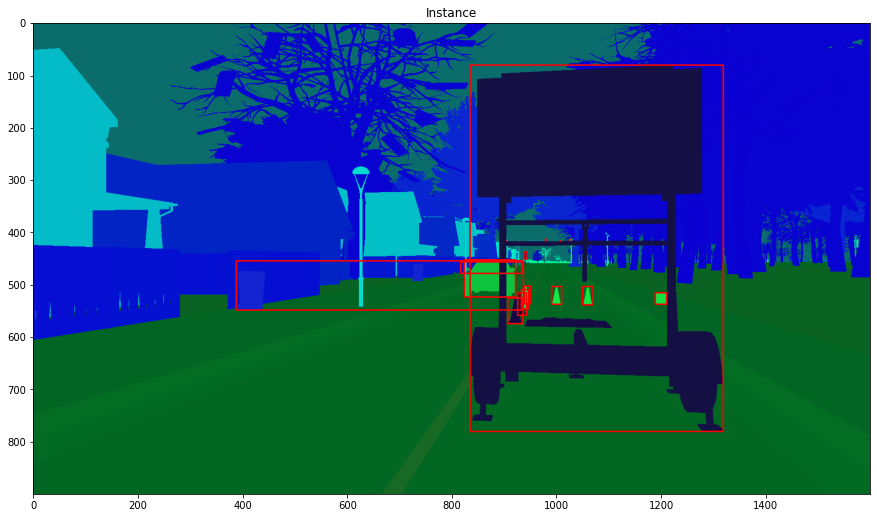

In [4]:
pixels = img_instance.reshape(-1, 3)

# get unique ids whose red channel is 14

unique_ids = np.unique(pixels, axis=0)

# print those with a unique red channel
# print("unique_ids: ", unique_ids)

# get only those whose red channel is 14, 12, 15, 16, 18, 19, 7
unique_ids = unique_ids[
    (unique_ids[:, 0] == 14)
    | (unique_ids[:, 0] == 12)
    | (unique_ids[:, 0] == 15)
    | (unique_ids[:, 0] == 16)
    | (unique_ids[:, 0] == 18)
    | (unique_ids[:, 0] == 19)
    | (unique_ids[:, 0] == 7)
    | (unique_ids[:, 0] == 8)
    | (unique_ids[:, 0] == 21) # static traffic warning
]

img_instance_copy = img_instance.copy()

bboxes_2d_list_inst = []
for id in unique_ids:
    positions = np.all(img_instance_copy == id, -1)
    positions = np.argwhere(positions)

    if positions.size > 0:
        min_y = np.min(positions[:, 0])
        max_y = np.max(positions[:, 0])
        min_x = np.min(positions[:, 1])
        max_x = np.max(positions[:, 1])
        bboxes_2d_list_inst.append([min_x, min_y, max_x, max_y])

    # draw a rectangle around the positions
    cv2.rectangle(
        img_instance_copy,
        (min_x, min_y),
        (max_x, max_y),
        (255, 0, 0),
        2,
    )

# show instance
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_instance_copy)
plt.title("Instance")
plt.show()


## 2D BBOXES FROM 3D

bboxes_2d_list:  [[ 820  452  925  526]
 [ 804  -16 1362  786]]
bboxes_2d_list_inst:  [[1007  416 1009  416]
 [ 979  412  980  416]
 [ 905  416  905  416]
 [1025  413 1026  415]
 [ 938  437  944  450]
 [ 824  452  922  523]
 [ 926  515  943  558]
 [ 817  456  934  478]
 [ 907  525  936  574]
 [ 835   80 1319  780]
 [ 388  454  937  548]
 [1189  515 1211  537]
 [1050  503 1070  538]
 [ 991  503 1010  537]
 [ 939  502  951  536]
 [ 933  509  947  546]]


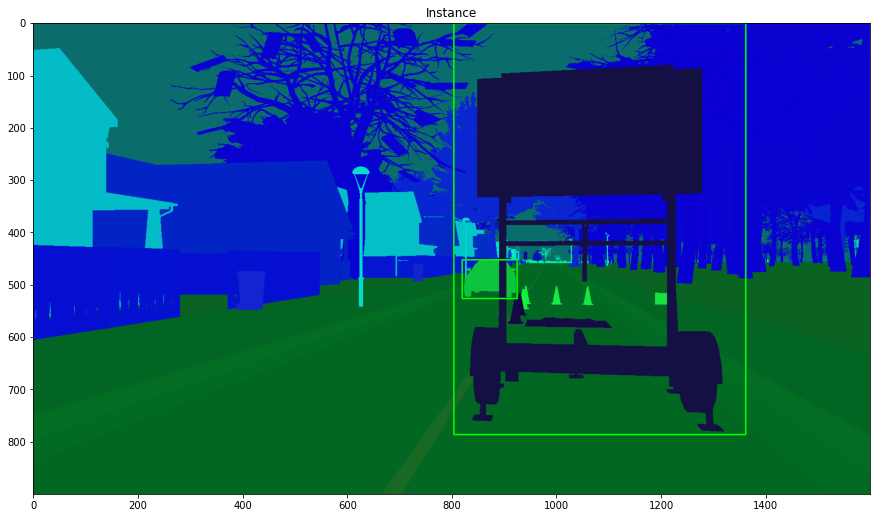

In [5]:
# open bboxes_2d_list.npy
bboxes_2d_list = np.load(f"dataset_scripts/bboxes_2d_list_{ITEM}.npy", allow_pickle=True)
bboxes_2d_list_inst = np.array(bboxes_2d_list_inst)

print("bboxes_2d_list: ", bboxes_2d_list)

print("bboxes_2d_list_inst: ", bboxes_2d_list_inst)

bboxes_2d_list_fixed = np.zeros((bboxes_2d_list.shape[0], 4))

img_instance_copy = img_instance.copy()

# draw them over the image
for i, bbox in enumerate(bboxes_2d_list):
    # get the bbox
    x1, y1, x2, y2 = bbox[:4]

    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > img_instance.shape[1]:
        x2 = img_instance.shape[1]
    if y2 > img_instance.shape[0]:
        y2 = img_instance.shape[0]

    bbox_2d = np.array([x1, y1, x2, y2])
    bboxes_2d_list_fixed[i] = bbox_2d

    # draw a rectangle around the bbox
    cv2.rectangle(
        img_instance_copy,
        (int(x1), int(y1)),
        (int(x2), int(y2)),
        (0, 255, 0),
        2,
    )
# show instance
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_instance_copy)
plt.title("Instance")
plt.show()

In [6]:
print("bboxes_2d_list_fixed: ", bboxes_2d_list_fixed)
print("bboxes_2d_list_inst: ", bboxes_2d_list_inst)

bboxes_2d_list_fixed:  [[ 820.  452.  925.  526.]
 [ 804.    0. 1362.  786.]]
bboxes_2d_list_inst:  [[1007  416 1009  416]
 [ 979  412  980  416]
 [ 905  416  905  416]
 [1025  413 1026  415]
 [ 938  437  944  450]
 [ 824  452  922  523]
 [ 926  515  943  558]
 [ 817  456  934  478]
 [ 907  525  936  574]
 [ 835   80 1319  780]
 [ 388  454  937  548]
 [1189  515 1211  537]
 [1050  503 1070  538]
 [ 991  503 1010  537]
 [ 939  502  951  536]
 [ 933  509  947  546]]


# 2D BBOXES FROM BOTH

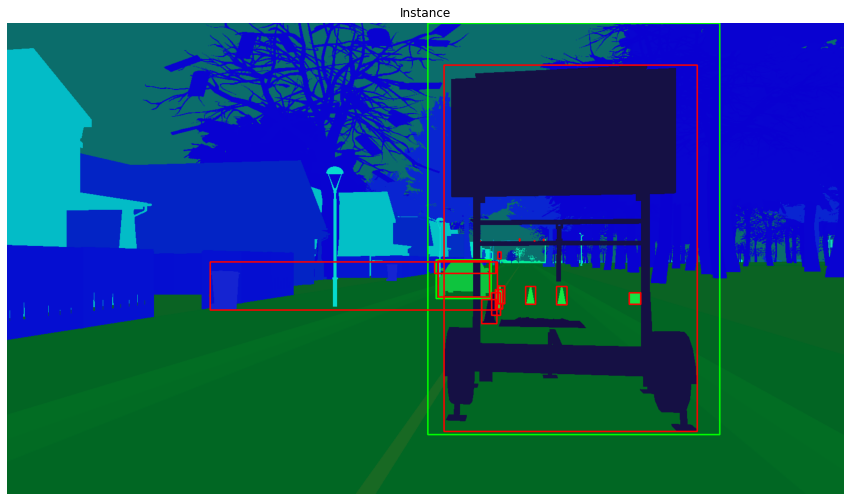

In [7]:
bboxes_2d_list_inst = []
for id in unique_ids:
    positions = np.all(img_instance_copy == id, -1)
    positions = np.argwhere(positions)

    if positions.size > 0:
        min_y = np.min(positions[:, 0])
        max_y = np.max(positions[:, 0])
        min_x = np.min(positions[:, 1])
        max_x = np.max(positions[:, 1])
        bboxes_2d_list_inst.append([min_x, min_y, max_x, max_y])

    # draw a rectangle around the positions
    cv2.rectangle(
        img_instance_copy,
        (min_x, min_y),
        (max_x, max_y),
        (255, 0, 0),
        2,
    )

# show instance
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_instance_copy)
plt.title("Instance")
plt.axis("off")
plt.show()

## 2D BBOXES FROM ASSOCIATION

len(bboxes_2d_list):  2
len(bboxes_2d_list_inst):  16
bboxes_2d_list_associated:  [[ 824  454  922  523]
 [ 835   80 1319  780]]


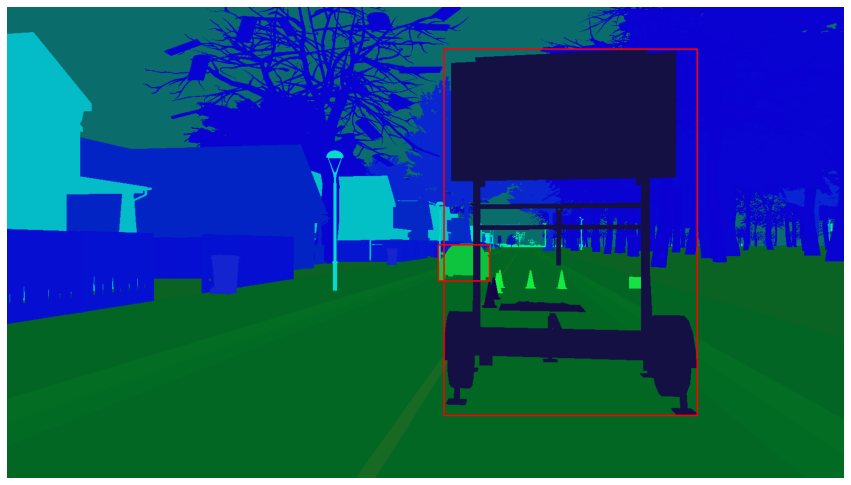

In [8]:
bboxes_2d_list_associated = []

print(f"len(bboxes_2d_list): ", len(bboxes_2d_list))
print(f"len(bboxes_2d_list_inst): ", len(bboxes_2d_list_inst))

def compute_iou(boxA, boxB):
    # Coordenadas del área de intersección
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Área de intersección
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    # Área de cada caja
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    # IoU
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

iou_threshold = 0.2
if len(bboxes_2d_list) > len(bboxes_2d_list_inst):
    for i, inst in enumerate(bboxes_2d_list_inst):
        best_iou = 0
        best_match = -1
        for j, geom_2d in enumerate(bboxes_2d_list):
            iou = compute_iou(inst, geom_2d)
            if iou > best_iou:
                best_iou = iou
                best_match = j
        if best_iou >= iou_threshold:
            bboxes_2d_list_associated.append(bboxes_2d_list_inst[i]) # always keep the instance
else:
    for i, geom_2d in enumerate(bboxes_2d_list):
        best_iou = 0
        best_match = -1
        for j, inst in enumerate(bboxes_2d_list_inst):
            iou = compute_iou(geom_2d, inst)
            if iou > best_iou:
                best_iou = iou
                best_match = j
        if best_iou >= iou_threshold:
            bboxes_2d_list_associated.append(bboxes_2d_list_inst[best_match]) # always keep the instance

print("bboxes_2d_list_associated: ", np.array(bboxes_2d_list_associated)) 

# draw the associated bboxes
img_instance_copy = img_instance.copy()
# draw them over the image
for i, bbox in enumerate(bboxes_2d_list_associated):
    # get the bbox
    x1, y1, x2, y2 = bbox[:4]

    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > img_instance.shape[1]:
        x2 = img_instance.shape[1]
    if y2 > img_instance.shape[0]:
        y2 = img_instance.shape[0]

    # if area is very small, continue
    if (x2 - x1) * (y2 - y1) < 5:
        continue

    # draw a rectangle around the bbox
    cv2.rectangle(
        img_instance_copy,
        (int(x1), int(y1)),
        (int(x2), int(y2)),
        (255, 0, 0),
        2,
    )
# show instance
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_instance_copy)
plt.axis("off")
plt.show()

# 2D BBOXES FROM FINAL LABELS (CHECK)

img shape:  (900, 1600, 3)


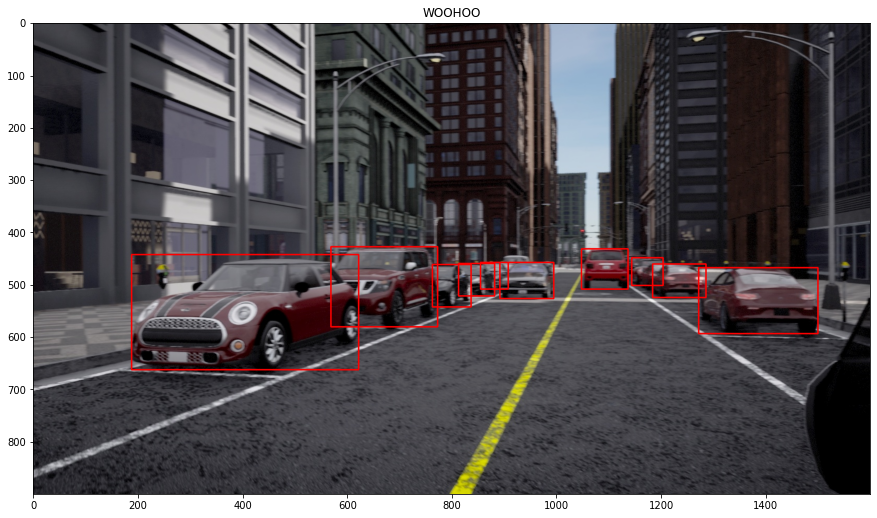

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys

'do nothing' if 'np' not in globals() else np.set_printoptions(3, suppress=True);

ITEM = "0050"

LABEL_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new/route_route0_routes_training_date_05_23_11_36_25/labels/" + ITEM + ".txt"
CAM_FRONT_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new/route_route0_routes_training_date_05_23_11_36_25/CAM_FRONT/" + ITEM + ".jpg"

# LOAD
img = cv2.imread(CAM_FRONT_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.array(img)
print("img shape: ", img.shape)

# load label
with open(LABEL_PATH, "r") as f:
    lines = f.readlines()
    lines = [line.strip() for line in lines]
    label = [line.split(" ") for line in lines]

for obj in label:
    if len(obj) == 9:
        continue # object with no 2d BBox
    else:
        cls, x, y, z, w, h, l, yaw, _, u_min, v_min, u_max, v_max = obj

    cv2.rectangle(
        img,
        (int(float(u_min)), int(float(v_min))),
        (int(float(u_max)), int(float(v_max))),
        (255, 0, 0),
        2,
    )
# show instance
fig = plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.title("WOOHOO")
plt.show()


# TEST POINTCLOUDS

z min:  -1.9919140338897705
z max:  14.736085966110231


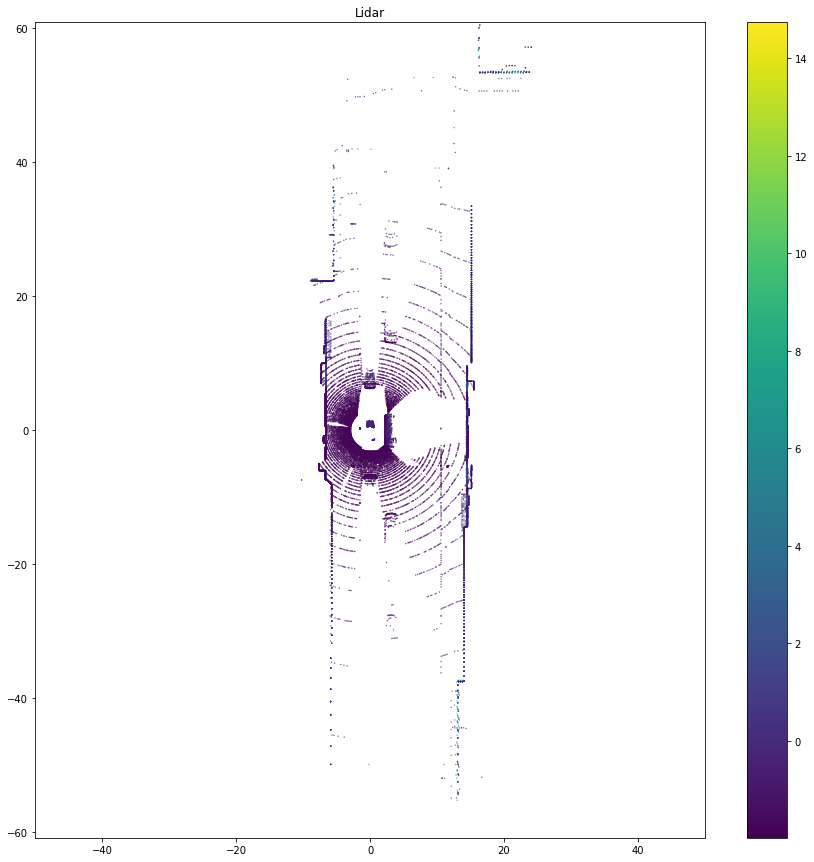

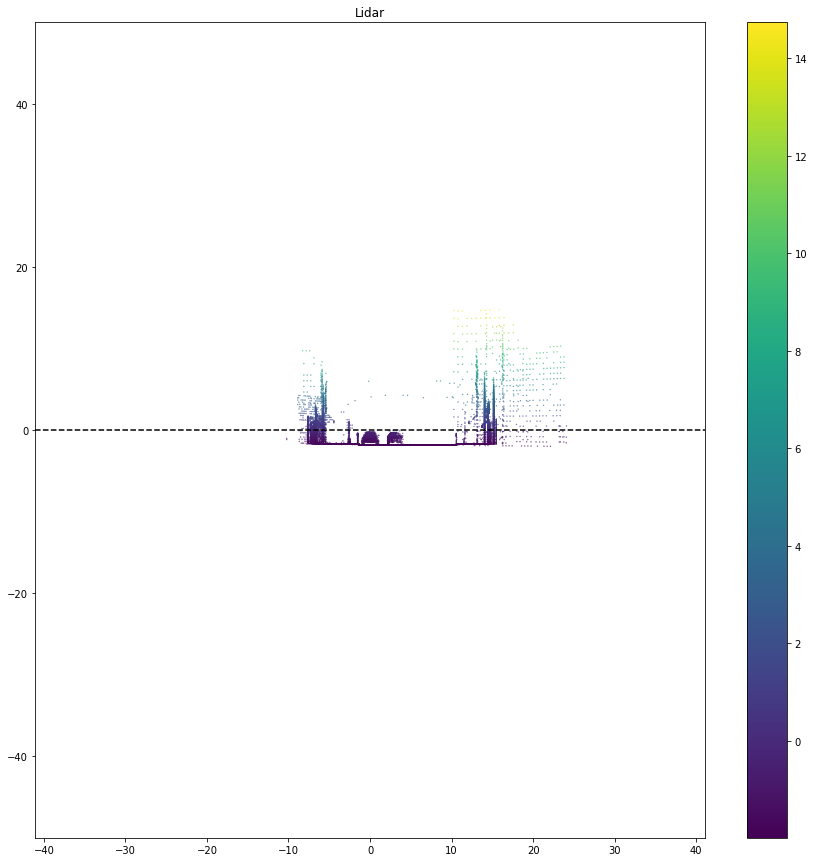

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import laspy

'do nothing' if 'np' not in globals() else np.set_printoptions(3, suppress=True);

ITEM = "0001"

LABEL_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new/route_route14_routes_training_date_05_27_02_09_42/labels/" + ITEM + ".txt"
CAM_FRONT_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new/route_route14_routes_training_date_05_27_02_09_42/CAM_FRONT/" + ITEM + ".jpg"
PATH_LIDAR = "/home/nupdm/Datasets/nuPDM/routes_training_new/route_route14_routes_training_date_05_27_02_09_42/lidar/" + ITEM + ".laz"
# PATH_BIN_LIDAR = "/home/nupdm/Datasets/nuPDM/routes_training_new/route_route14_routes_training_date_05_27_02_09_42/points/" + ITEM + ".bin"
CALIB_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new/route_route14_routes_training_date_05_27_02_09_42/calib/" + ITEM + ".txt"


with laspy.open(PATH_LIDAR) as f:
    points = f.read()

# import pdb; pdb.set_trace()

x = points['X']/1000 + f.header.offset[0]
y = -(points['Y']/1000 + f.header.offset[1])
z = points['Z']/1000 + f.header.offset[2]
i = points['intensity']

print("z min: ", np.min(z))
print("z max: ", np.max(z))

# show in plt bev
fig = plt.figure(figsize=(15, 15))
plt.scatter(x, y, c=z, s=0.1)
plt.title("Lidar")
plt.axis("equal")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.colorbar()
plt.show()

# show left view of the point cloud
fig = plt.figure(figsize=(15, 15))
plt.scatter(x, z, c=z, s=0.1)
plt.title("Lidar")
plt.axis("equal")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
# draw horizontal line in z = 0
plt.axhline(y=0, color='k', linestyle='--')
plt.colorbar()
plt.show()

# lidar_bin = np.fromfile(PATH_BIN_LIDAR, dtype=np.float32)
# lidar_bin = lidar_bin.reshape(-1, 4)

# # print min and max
# print("lidar_bin shape: ", lidar_bin.shape)
# print("lidar_bin min: ", np.min(lidar_bin, axis=0))
# print("lidar_bin max: ", np.max(lidar_bin, axis=0))

# # show in plt bev
# fig = plt.figure(figsize=(15, 15))
# plt.scatter(lidar_bin[:, 0], lidar_bin[:, 1], c=lidar_bin[:, 2], s=0.1)
# plt.title("Lidar Bin")
# plt.axis("equal")
# plt.xlim(-50, 50)
# plt.ylim(-50, 50)
# plt.colorbar()
# plt.show()

# # show left view of the point cloud
# fig = plt.figure(figsize=(15, 15))
# plt.scatter(lidar_bin[:, 0], lidar_bin[:, 2], c=lidar_bin[:, 2], s=0.1)
# plt.title("Lidar Bin")
# plt.axis("equal")
# plt.xlim(-50, 50)
# plt.ylim(-50, 50)
# # draw horizontal line in z = 0
# plt.axhline(y=0, color='k', linestyle='--')
# plt.colorbar()
# plt.show()


# Project LiDAR to camera

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import laspy

'do nothing' if 'np' not in globals() else np.set_printoptions(3, suppress=True);

ITEM = "0070"

LABEL_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new/route_route14_routes_training_date_05_27_02_09_42/labels/" + ITEM + ".txt"
CAM_FRONT_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new/route_route14_routes_training_date_05_27_02_09_42/CAM_FRONT/" + ITEM + ".jpg"
# PATH_LIDAR = "/home/nupdm/Datasets/nuPDM/routes_training_new/route_route14_routes_training_date_05_27_02_09_42/lidar/" + ITEM + ".laz"
PATH_LIDAR = "/home/nupdm/Datasets/nuPDM/routes_training_new/route_route14_routes_training_date_05_27_02_09_42/points/" + ITEM + ".bin"
CALIB_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new/route_route14_routes_training_date_05_27_02_09_42/calib/" + ITEM + ".txt"

img = cv2.imread(CAM_FRONT_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.array(img)

with laspy.open(PATH_LIDAR) as f:
    points = f.read()

x = points['X']/1000 + f.header.offset[0]
y = points['Y']/1000 + f.header.offset[1]
z = points['Z']/1000 + f.header.offset[2]
i = points['intensity']

# lidar_data = np.fromfile(PATH_LIDAR, dtype=np.float32).reshape(-1, 4)  # Load lidar data

lidar_data = np.ones((len(x), 4), dtype=np.float32)
lidar_data[:, 0] = x
lidar_data[:, 1] = y
lidar_data[:, 2] = z

print("lidar_data shape: ", lidar_data.shape)

# show in bev
fig = plt.figure(figsize=(15, 15))
plt.scatter(lidar_data[:, 0], lidar_data[:, 1], c=lidar_data[:, 2], s=0.1)
plt.title("Lidar Data")
plt.axis("equal")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.colorbar()
plt.show()

with open(CALIB_PATH, 'r') as f:
    lines = f.readlines()
    lines = [line.strip() for line in lines]

    CAM_FRONT_K = np.array([
                                float(info) for info in lines[0].split(' ')[1:]
                            ]).reshape([4, 4])
    LIDAR2CAM_FRONT = np.array([
                                float(info) for info in lines[6].split(' ')[1:17]
                            ]).reshape([4, 4])
    LIDAR2EGO = np.array([
                                float(info) for info in lines[12].split(' ')[1:17]
                            ]).reshape([4, 4])
    
print("CAM_FRONT_K: ", CAM_FRONT_K)
print("LIDAR2CAM_FRONT: ", LIDAR2CAM_FRONT)
print("LIDAR2EGO: ", np.linalg.inv(LIDAR2EGO))  # Inverse of LIDAR2EGO

lidar_data_front = np.dot(LIDAR2CAM_FRONT, lidar_data.T).T  # Transform to camera coordinates
# Filter points with z < 0
lidar_data_front = lidar_data_front[lidar_data_front[:, 2] > 0]  # Keep only points with z > 0

lidar_data_front = np.dot(CAM_FRONT_K, lidar_data_front.T).T
lidar_data_front[:, 0] /= lidar_data_front[:, 2]
lidar_data_front[:, 1] /= lidar_data_front[:, 2]

# Filter points within image bounds
lidar_data_front = lidar_data_front[
    (lidar_data_front[:, 0] >= 0) & (lidar_data_front[:, 0] < img.shape[1]) &
    (lidar_data_front[:, 1] >= 0) & (lidar_data_front[:, 1] < img.shape[0])
]

# Show the projected lidar points on the camera image
fig = plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.scatter(lidar_data_front[:, 0], lidar_data_front[:, 1], s=7.5, c=lidar_data_front[:, 2], alpha=1)
plt.axis('off')
plt.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: '/home/nupdm/Datasets/nuPDM/routes_training_new/route_route14_routes_training_date_05_27_02_09_42/points/0070.bin'